## Importing Libraries

In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, date, timedelta
from dateutil.relativedelta import relativedelta
import plotly.graph_objects as go

import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

import holidays
us_holidays = holidays.UnitedStates()

This is a two-week long homework composed of the following portions:

1. Bond construction 
2. Duration calculation (should be pretty simple!)
3. Using the FRED API to plot the yield/forward/zero curve
4. Using treasury coupon bond prices as of 09/19/2025 to bootstrap spot rates from coupon bonds. 
    Write a small piece comparing that with the zero curve. 
5. From the spot curve in Q4, plot the forward curve and classify the yield shape (is it inverted/normal etc)


For all data collection purposes get the data as of **09/19/2025**.

# Question 1

Constructure hypothetical treasury par bond of a given time to maturity (in years) with given yield that pays semiannual coupons. Just define the functions.

In [ ]:
class Treasury_Par_Bond:

    n_bonds = 0

    # ----- Instance Details -----
    def __init__(self, fv, ytm, freq, T, issue_date: date): # force issue date to be entered 
        self.fv = fv
        self.ytm = ytm
        self.freq = freq
        self.T = T

        # accept str or date for issue_date
        self.issue_date = issue_date if isinstance(issue_date, date) else date.fromisoformat(issue_date)

        # For a par bond, coupon rate = YTM
        self.coupon_rate = ytm

        # Total number of payments
        self.n_periods = self.T * self.freq # N

        # Counting the number of bonds
        Treasury_Par_Bond.n_bonds += 1

    # ----- Helper Functions -----
    def yield_per_coupon(self):
        return self.ytm / self.freq

    def discount_factor(self, t):
        """ 
        Don't directly use n_periods. 
        Discount factor is individualised for each payment.
        
        """
        return 1 / ((1 + self.yield_per_coupon()) ** t)

    @staticmethod
    def is_business_day(d: date, holidays=us_holidays) -> bool:
        return d.weekday() < 5 and (not holidays or d not in holidays)

    @staticmethod
    def adjusted_business_day(d: date, holiday_calendar=us_holidays) -> date:
        """
        Roll forward to the next business day if d is weekend/holiday.
        
        """
        while d.weekday() >= 5 or d in holiday_calendar:  # 5=Sat, 6=Sun
            d += timedelta(days=1)
        
        return d
    
    @staticmethod
    def get_settlement_date_from_trade_date(trade_date, holidays=us_holidays):
        """
        US Treasury settlement: T+1 (roll forward for weekends/holidays).
        
        """
        # Base case: T+1 calendar day
        settlement_date = trade_date + timedelta(days=1)
        
        # Roll forward until business day
        while settlement_date.weekday() >= 5 or settlement_date in holidays:  # 5=Sat, 6=Sun
            settlement_date += timedelta(days=1)
        
        return settlement_date

    # ----- Value of Each Coupon Payment -----
    def coupon_payment(self):
        return self.fv * self.coupon_rate / self.freq

    # ----- Cash Flow Schedule for the Bond -----
    def cash_flows(self):
        """
        Returns a list of all coupon payments,
        with the face value added to the last payment. 
        
        """
        c = self.coupon_payment()
        cash_flows = [c] * self.n_periods # N coupon payments
        cash_flows[-1] += self.fv # Nth payment = coupon + principal

        return cash_flows 

    # ----- Bond Price from YTM -----
    def bond_price_from_ytm(self):
        """
        Returns the present value (price) of the bond
        based on its yield to maturity (ytm).

        Note: US Treasuries use discrete compounding discouting
        
        """
        cash_flows = self.cash_flows()
        bond_price = sum(cf * self.discount_factor(t) for t, cf in enumerate (cash_flows, start=1)) # returns (index, value)

        return bond_price

    # ----- Cash Flows of the Bond -----
    def table_of_cash_flows(self):
        """
        Returns a list of dicts: period t, cash_flow, discount_factor, present_value.

        """
        # Setting up coupon payment date calculation 
        months_between_payments = 12 // self.freq
        scheduled_coupon_payment_date = self.issue_date 

        table = []
        for t, cf in enumerate(self.cash_flows(), start=1):
            scheduled_coupon_payment_date += relativedelta(months = months_between_payments) # Add months_between_payments to the issue_date for payment date 
            
            # adjust coupon payment date if it is a holiday 
            actual_coupon_payment_date = Treasury_Par_Bond.adjusted_business_day(scheduled_coupon_payment_date)

            df = self.discount_factor(t)

            table.append({
                "t": t,
                "scheduled_date": scheduled_coupon_payment_date,   
                "coupon_payment_date": actual_coupon_payment_date, 
                "cash_flow": cf,
                "discount_factor": df,
                "present_value": cf * df
            })
        
        return table

    # ----- Accrued Interest, Dirty Price and Clean Price -----
    # Dirty Price = Clean Price + Accured Interest 

    def accrued_days(self, trade_date, holidays=us_holidays) -> int:
        settlement_date = self.get_settlement_date_from_trade_date(trade_date, holidays)
        coupon_payment_dates = [row["coupon_payment_date"] for row in self.table_of_cash_flows()]

        if settlement_date >= coupon_payment_dates[-1]:
            return 0

        if settlement_date < coupon_payment_dates[0]:
            return max(0, (settlement_date - self.issue_date).days)

        for i in range(1, len(coupon_payment_dates)):
            if coupon_payment_dates[i-1] <= settlement_date < coupon_payment_dates[i]:
                last_coupon_date = coupon_payment_dates[i-1]
                return (settlement_date - last_coupon_date).days

        return 0

    def days_in_coupon_period(self, trade_date, holidays=us_holidays) -> int:
        """
        Actual days in the current coupon period (denominator for Actual/Actual).
        If pre-first-coupon: (first_coupon - issue_date). If post-final: 0.

        """
        settlement_date = self.get_settlement_date_from_trade_date(trade_date, holidays)
        coupon_payment_dates = [row["coupon_payment_date"] for row in self.table_of_cash_flows()]

        # After (or on) final coupon -> no period
        if settlement_date >= coupon_payment_dates[-1]:
            return 0

        # Before first coupon -> period is (first_coupon - issue_date)
        if settlement_date < coupon_payment_dates[0]:
            return (coupon_payment_dates[0] - self.issue_date).days

        # Between coupons
        for i in range(1, len(coupon_payment_dates)):
            if coupon_payment_dates[i-1] <= settlement_date < coupon_payment_dates[i]:
                last_coupon_date = coupon_payment_dates[i-1]
                next_coupon_date = coupon_payment_dates[i]
                return (next_coupon_date - last_coupon_date).days

        return 0

    def accrued_fraction(self, trade_date, holidays=us_holidays):
        """
        Actual/Actual fraction elapsed in the current coupon period.
        
        """
        denom = self.days_in_coupon_period(trade_date, holidays)
        
        if denom <= 0:
            return 0.0
        
        numer = self.accrued_days(trade_date, holidays)  

        x = numer / denom
        
        return 0.0 if x < 0 else (0.999999 if x >= 1 else x)
    

    def accrued_interest(self, trade_date, holidays=us_holidays):
        """
        Accrued = coupon per period × accrued_fraction (Actual/Actual).
        
        """
        return self.coupon_payment() * self.accrued_fraction(trade_date, holidays)

    def clean_price(self):
        """
        Quoted clean price (uses coupon-date PV).
        
        """
        return self.bond_price_from_ytm()

    def dirty_price_from_trade(self, trade_date, holidays=us_holidays) -> float:
        """
        Dirty = Clean + Accrued (accrued computed at settlement).
        
        """
        return self.clean_price() + self.accrued_interest(trade_date, holidays)

    # ----- Bond Duration -----
    def macaulay_duration(self):
        """
        Macaulay Duration (in years).
        
        """
        price = self.bond_price_from_ytm()
        weighted_sum = sum(
            t * cf * self.discount_factor(t)
            for t, cf in enumerate(self.cash_flows(), start=1)
        )
        
        return weighted_sum / price / self.freq  # divide by freq to convert periods -> years

    def modified_duration(self):
        mod_duration = self.macaulay_duration() / (1 + self.yield_per_coupon())

        return mod_duration

    def pv01(self) -> float:
        """
        Price Value of 1bp (DV01).
        
        """
        return self.modified_duration() * self.clean_price() * 0.0001

    
    def convexity(self) -> float:
        price = self.bond_price_from_ytm()
        
        if price <= 0:
            return 0.0
        
        per = self.yield_per_coupon()
        
        conv_per_period = (
            sum(
                cf * t * (t + 1) * self.discount_factor(t+2)
                for t, cf in enumerate(self.cash_flows(), start=1)
            ) / price
        )
        
        return conv_per_period / (self.freq ** 2)

    def dollar_convexity(self) -> float:
        """
        Dollar convexity = price × convexity
        
        """
        return self.clean_price() * self.convexity()

In [3]:
# Instantiate a 5y semiannual par Treasury (issue dated 2025-01-01)
bond_1 = Treasury_Par_Bond(1000, 0.03, 2, 5, '2025-01-01')

print("Face Value: ", f"${bond_1.fv:,.2f}")
print("YTM: ", f"{bond_1.ytm:.2%}")  

print("Coupon Frequency:", bond_1.freq)
print("Maturity (years):", bond_1.T)
print("Number of Periods:", bond_1.n_periods)

print("\nCoupon Payment per Period:", f"${bond_1.coupon_payment():,.2f}")
print("Cash Flows:", [f"${cf:,.2f}" for cf in bond_1.cash_flows()])
print(f"Bond Price from YTM (Clean): ${bond_1.bond_price_from_ytm():,.2f}")

print("\n--- Cash Flow Table ---")
for row in bond_1.table_of_cash_flows():
    print(
        f"t={row['t']:2d}, "
        f"Scheduled={row['scheduled_date']}, "
        f"Payment Date={row['coupon_payment_date']}, "
        f"CF=${row['cash_flow']:,.2f}, "
        f"DF={row['discount_factor']:.6f}, "
        f"PV=${row['present_value']:,.2f}"
    )

# ---- Accrued, Clean, and Dirty Prices ----
trade_date = date(2025, 6, 10)   
settlement_date = bond_1.get_settlement_date_from_trade_date(trade_date)

print("\n--- Pricing ---")
print(f"Trade Date: {trade_date}")
print(f"Settlement Date: {settlement_date}")
print(f"Accrued Days: {bond_1.accrued_days(trade_date)}")
print(f"Days in Coupon Period: {bond_1.days_in_coupon_period(trade_date)}")
print(f"Accrued Fraction: {bond_1.accrued_fraction(trade_date):.2f}")
print(f"Accrued Interest: ${bond_1.accrued_interest(trade_date):,.2f}")
print(f"Clean Price: ${bond_1.clean_price():,.2f}")
print(f"Dirty Price: ${bond_1.dirty_price_from_trade(trade_date):,.2f}")

# ---- Duration ----
print("\n--- Duration ---")
print(f"Macaulay Duration (years): {bond_1.macaulay_duration():.2f}")
print(f"Modified Duration (years): {bond_1.modified_duration():.2f}")
print(f"PV01: ${bond_1.pv01():,.2f}")

# ---- Convexity ----
print("\n--- Convexity ---")
print(f"Convexity: {bond_1.convexity():,.2f}")
print(f"Dollar Convexity: ${bond_1.dollar_convexity():,.2f}")


Face Value:  $1,000.00
YTM:  3.00%
Coupon Frequency: 2
Maturity (years): 5
Number of Periods: 10

Coupon Payment per Period: $15.00
Cash Flows: ['$15.00', '$15.00', '$15.00', '$15.00', '$15.00', '$15.00', '$15.00', '$15.00', '$15.00', '$1,015.00']
Bond Price from YTM (Clean): $1,000.00

--- Cash Flow Table ---
t= 1, Scheduled=2025-07-01, Payment Date=2025-07-01, CF=$15.00, DF=0.985222, PV=$14.78
t= 2, Scheduled=2026-01-01, Payment Date=2026-01-02, CF=$15.00, DF=0.970662, PV=$14.56
t= 3, Scheduled=2026-07-01, Payment Date=2026-07-01, CF=$15.00, DF=0.956317, PV=$14.34
t= 4, Scheduled=2027-01-01, Payment Date=2027-01-04, CF=$15.00, DF=0.942184, PV=$14.13
t= 5, Scheduled=2027-07-01, Payment Date=2027-07-01, CF=$15.00, DF=0.928260, PV=$13.92
t= 6, Scheduled=2028-01-01, Payment Date=2028-01-03, CF=$15.00, DF=0.914542, PV=$13.72
t= 7, Scheduled=2028-07-01, Payment Date=2028-07-03, CF=$15.00, DF=0.901027, PV=$13.52
t= 8, Scheduled=2029-01-01, Payment Date=2029-01-02, CF=$15.00, DF=0.887711, PV

# Question 2

Calculate its duration (Macaulay Bond Duration)

### Answered above. 

Method is defined as macaulay_duration. 

# Question 3 
Use the FRED API to get the yields by maturity.  Plot the yield curve, forward curve and zero curve. 

In [4]:
# FRED series IDs for Treasury par yields by maturity 

# US Gov bond interest rates for different maturities 
# <= 1 year - T-Bills
# 2 - 10 years - T-Notes 
# 20 and 30 years - T-Bonds 

series_ids = { '3M': 'DGS3MO'
                , '6M': 'DGS6MO'
                , '1Y': 'DGS1'
                , '2Y': 'DGS2'
                , '3Y': 'DGS3'
                , '5Y': 'DGS5'
                , '7Y': 'DGS7'
                , '10Y': 'DGS10'
                , '20Y': 'DGS20'
                , '30Y': 'DGS30' }

API_KEY = "a6710e81fd45204490adffed360ffd42"

In [ ]:
def fetch_fred_series(series_id, start=None, end=None, api_key=None):
    """
    Fetch a FRED series into a pandas Series
    Skips missing '.' values and raises on HTTP errors.

    ---- Notes ----
    JSON is easiest to parse in Python. 
    `requests` library has .json() built in to get a Python dictionary
    
    """
    url = "https://api.stlouisfed.org/fred/series/observations"

    params = {"series_id": series_id, "file_type": "json"}
    if api_key: params["api_key"] = api_key
    if start:   params["observation_start"] = start
    if end:     params["observation_end"] = end

    r = requests.get(url, params=params)
    r.raise_for_status()  # raise if HTTP error

    # what the data looks like -> https://fred.stlouisfed.org/docs/api/fred/series_observations.html#example_json
    data = r.json() # .json() converts data into a python dict

    # this is a list of dictionaries
    obs = data.get("observations", []) # .get(key, default) is a dictionary method that takes. default -> value to return if data is not available

    # creating two columns extracted from obs to get date and yield for that date
    dates, vals = [], [] # create empty lists 
    for o in obs:
        # what to do if there is no value
        v = o.get("value", ".")
        if v == ".":
            continue  # skip missing
        
        # add the date to date column
        dates.append(datetime.strptime(o["date"], "%Y-%m-%d"))
        # add the yields to values column
        vals.append(float(v))  # FRED yields are in PERCENT (e.g., 4.25)

    # return the data in a series format with index as the date 
    return pd.Series(vals, index=dates, name=series_id)

In [6]:
curves = {}

for label, fred_id in series_ids.items():  
    
    curves[label] = fetch_fred_series(
        fred_id, 
        start="2025-01-01", 
        end="2025-12-31", 
        api_key=API_KEY
    )

curve_df = pd.DataFrame(curves)  # rows=dates, cols=labels (3M..30Y)

print("Shape:", curve_df.shape)

Shape: (187, 10)


In [7]:
curve_df.head()

,3M,6M,1Y,2Y,3Y,5Y,7Y,10Y,20Y,30Y
2025-01-02,4.36,4.25,4.17,4.25,4.29,4.38,4.47,4.57,4.86,4.79
2025-01-03,4.34,4.25,4.18,4.28,4.32,4.41,4.51,4.60,4.88,4.82
2025-01-06,4.35,4.24,4.17,4.28,4.30,4.42,4.52,4.62,4.91,4.85
2025-01-07,4.35,4.24,4.19,4.30,4.33,4.46,4.57,4.67,4.97,4.91
2025-01-08,4.35,4.25,4.19,4.28,4.31,4.45,4.56,4.67,4.97,4.91


In [8]:
# ----- 1. PLOT TREASURY PAR YIELD CURVE ----- 

# curve_df: rows=dates , cols=['3M','6M','1Y',...,'30Y'] in PERCENT
MAT_YEARS = {"3M":0.25,"6M":0.5,"1Y":1,"2Y":2,"3Y":3,"5Y":5,"7Y":7,"10Y":10,"20Y":20,"30Y":30}

cols = [c for c in MAT_YEARS if c in curve_df.columns]
x = np.array([MAT_YEARS[c] for c in cols])

# Build frames
df_complete = curve_df[cols].dropna()
dates = df_complete.index

frames = []
for d in dates:
    y = df_complete.loc[d].values  # yields in %
    frames.append(go.Frame(data=[go.Scatter(x=x, y=y, mode="lines+markers")],
                           name=str(d.date())))
    
fig = go.Figure(
    data=[go.Scatter(x=x, y=df_complete.iloc[0].values, mode="lines+markers")]
    , layout=go.Layout(

        title="U.S. Treasury Yield Curve (daily)"
        , xaxis=dict(title="Maturity (in years)", range=[0, 35])
        , yaxis=dict(title="Yield (%)", range=[3.3,5.5])
        , width=1000 , height=600
        , updatemenus=[{
            "type": "buttons"
            , "buttons": [
                {"label": "Play", "method": "animate",
                 "args": [None, {"frame": {"duration": 100, "redraw": True},
                                 "fromcurrent": True, "transition": {"duration": 0}}]}
                , {"label": "Pause", "method": "animate",
                 "args": [[None], {"frame": {"duration": 0, "redraw": False},
                                   "mode": "immediate"}]},
            ]
        }]
        , sliders=[{
            "steps": [{"args": [[str(d.date())],
                        {"frame": {"duration": 0, "redraw": True}, "mode": "immediate"}],
                       "label": str(d.date()), "method": "animate"} for d in dates]
            , "currentvalue": {"prefix": "Date: "}
        }]
    )
    , frames=frames
)

fig.show()

In [9]:
# Extract the data for 19-Sep-2025
yields_1909 = curve_df.loc['2025-09-19'] 

# Convert the Series index to years
yields_1909 = yields_1909.rename(index=lambda s: float(s[:-1]) / 12 if s.endswith("M") else float(s[:-1]))
# Yields/100
yields_1909 = yields_1909/ 100

yields = yields_1909.rename('par_yields').to_frame()
yields.index.name = 'maturities'

yields

,par_yields
maturities,
0.25,0.0403
0.50,0.0381
1.00,0.0360
2.00,0.0357
3.00,0.0356
5.00,0.0368
7.00,0.0388
10.00,0.0414
20.00,0.0471


In [ ]:
def compute_zero_forward_from_par(yields):
    """
    Expects:
      - index: maturities in years (float)
      - column 'par_yields': yields in decimals (e.g., 0.0425)

    Adds:
      - 'Zero'    : continuous zero rate, z(T) = -ln(DF)/T
      - 'Forward' : continuous forward over [T_{i-1}, T_i] = Δ(z*T)/ΔT (first = NaN)

    """
    y = yields.sort_index().copy()

    T = y.index.to_numpy(dtype=float)                # maturities (years)
    r = y["par_yields"].to_numpy(dtype=float)       # yields (decimal)

    DF = np.power(1.0 + r, -T)

    Zero = np.where(T > 0.0, -np.log(DF) / T, np.nan)

    zT = Zero * T
    Forward = np.r_[np.nan, np.diff(zT) / np.diff(T)] if T.size >= 2 else np.array([np.nan])

    y["zero_yields"] = Zero
    y["fwd_yields"] = Forward

    return y

In [11]:
yields_par_zero_fwd_df = compute_zero_forward_from_par(yields)
yields_par_zero_fwd_df

,par_yields,zero_yields,fwd_yields
maturities,,,
0.25,0.0403,0.039509,NaN
0.50,0.0381,0.037392,0.035275
1.00,0.0360,0.035367,0.033342
2.00,0.0357,0.035078,0.034788
3.00,0.0356,0.034981,0.034788
5.00,0.0368,0.036139,0.037876
7.00,0.0388,0.038066,0.042884
10.00,0.0414,0.040566,0.046399
20.00,0.0471,0.046024,0.051483


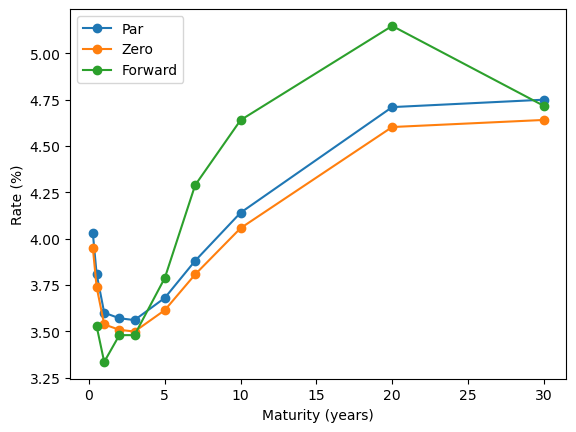

In [12]:
x = yields_par_zero_fwd_df.index.astype(float).to_numpy()
par = yields_par_zero_fwd_df["par_yields"].to_numpy() * 100
zero = yields_par_zero_fwd_df["zero_yields"].to_numpy() * 100

fwd_series = yields_par_zero_fwd_df["fwd_yields"].dropna()
xfwd = fwd_series.index.astype(float).to_numpy()
fwd  = fwd_series.to_numpy() * 100

plt.figure()
plt.plot(x, par,  marker="o", label="Par")
plt.plot(x, zero, marker="o", label="Zero")
plt.plot(xfwd, fwd,  marker="o", label="Forward")
plt.xlabel("Maturity (years)")
plt.ylabel("Rate (%)")
plt.legend()
plt.show()

# Question 4
Bootstrap spot Rates from coupon bonds - use the FRED API or Bloomberg to get the treasury prices/yields - do this till the 30Y. 

In [ ]:
def bootstrap_spot_from_par_df(df, freq=2, par=100.0):

    s = df['par_yields'].dropna().sort_index()

    step  = 1.0 / freq
    max_T = float(min(30.0, s.index.max()))
    Tgrid = np.arange(step, max_T + 1e-12, step)

    # interpolate par yields onto the coupon dates
    f = interp1d(s.index.values, s.values, kind='linear', bounds_error=True)
    ygrid = f(Tgrid)  

    # bootstrap continuous spots
    spot = np.zeros_like(Tgrid)
    for i in range(len(Tgrid)):
        T = Tgrid[i]
        y = ygrid[i]
        c = par * y / freq 

        if T <= 1.0:
            spot[i] = y
        else:
            pv = 0.0
            for k in range(1, int(T*freq)):   
                t_k = k / freq               
                z_k = spot[k-1]             
                pv += c * np.exp(-z_k * t_k)
            spot[i] = -(1.0 / T) * np.log((par - pv) / (par + c))

    DF = np.exp(-spot * Tgrid)

    return pd.DataFrame({
        "T_years": Tgrid,
        "par_interpolated": ygrid,
        "spot": spot,
        "DF": DF
    }

In [14]:
bootstrapped_spot = bootstrap_spot_from_par_df(yields_par_zero_fwd_df)
bootstrapped_spot.head()

,T_years,par_interp,spot,DF
0,0.5,0.03810,0.038100,0.981130
1,1.0,0.03600,0.036000,0.964640
2,1.5,0.03585,0.035511,0.948127
3,2.0,0.03570,0.035365,0.931713
4,2.5,0.03565,0.035318,0.915490


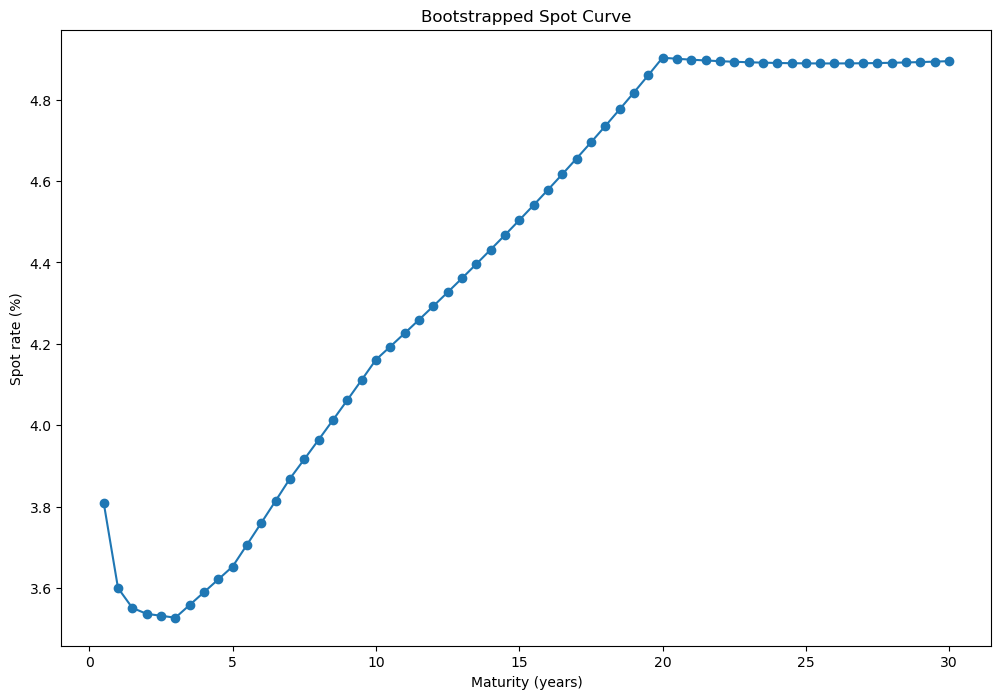

In [15]:
x = bootstrapped_spot["T_years"].to_numpy()
y = (bootstrapped_spot["spot"].to_numpy() * 100)   # convert to percent

plt.figure(figsize=(12,8))
plt.plot(x, y, marker="o")
plt.xlabel("Maturity (years)")
plt.ylabel("Spot rate (%)")
plt.title("Bootstrapped Spot Curve")
plt.show()

# Question 5
Calculate the 1 year forward rates from 1Y - 30Y (so 2Y1Y forward, 3Y1Y forward etc.). Plot the forward curve and classify the shape of it (inverted/normal etc.) Explain what that means!

In [ ]:
def compute_1y_forwards(boot_df):

    g = boot_df[["T_years", "DF"]].dropna().copy().set_index("T_years")
    
    key = np.round(g.index.values, 6)
    D   = dict(zip(key, g["DF"].values))

    starts, fwds = [], []
    for t in sorted(D.keys()):
        if t < 1.0:
            continue
        t1 = round(t + 1.0, 6)
        if t1 in D:
            f = np.log(D[t] / D[t1])        
            starts.append(t)
            fwds.append(f)

    return pd.DataFrame({"start_year": starts, "fwd_1y_cont": fwds})

In [17]:
fw1y = compute_1y_forwards(bootstrapped_spot)
fw1y.head()

,start_year,fwd_1y_cont
0,1.0,0.034731
1,1.5,0.035029
2,2.0,0.035079
3,2.5,0.036246
4,3.0,0.037779


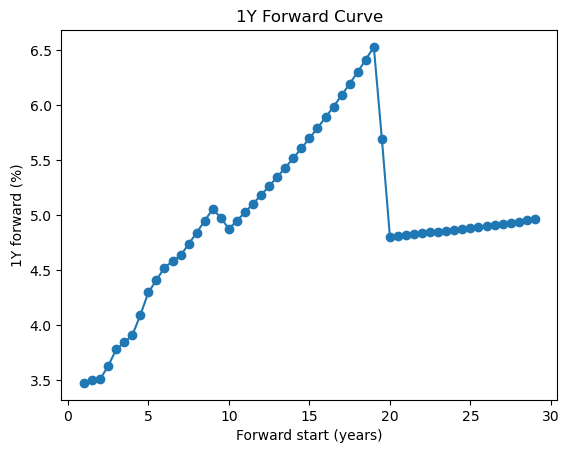

In [18]:
plt.figure()
plt.plot(fw1y["start_year"], fw1y["fwd_1y_cont"]*100, marker="o")
plt.xlabel("Forward start (years)")
plt.ylabel("1Y forward (%)")
plt.title("1Y Forward Curve")
plt.show()

In [19]:
# Humped: Medium-term forwards peak above both short and long ends. 
# Market expects rates to rise then fall.